<h1>Illustrations of numerical integration</h1>

<h2>Newton Cotes formulas and errors</h2>

<p>A Newton-Cotes formula uses an interpolating polynomial over $[a,b]$ to estimate $f$ and in turn the integral of $f$ over $[a,b]$. The nodes are evenly spaced, e.g.: <code>&#123;a&#125;</code>, <code>&#123;a,b&#125;</code>, <code>&#123;a,&#40;a&#43;b&#41;/2, b&#125;</code>, ...</p>

In [1]:
function interpolating_nodes(a, b, n)
  n == 0 && return [a]
  collect(linspace(a,b,n+1))
end

function l(i, nodes)
  length(nodes) == 1 && return(x -> 1.0)
  x -> begin
    prod((x-nodes[j])/(nodes[i]-nodes[j]) for j in eachindex(nodes) if i !== j)
  end
end

function poly_interp(f, nodes)
  x -> sum(f(nodes[i]) * l(i, nodes)(x) for i in eachindex(nodes))
end

function quadrature(f, a, b, nodes)
	As = [quadgk(l(i, nodes), a, b)[1] for i in eachindex(nodes)]
	sum(f(nodes[i]) * As[i] for i in eachindex(nodes))
end
   
function newton_cotes(f, a, b, n)
  nodes = interpolating_nodes(a, b, n)
  quadrature(f, a, b, nodes)
end

newton_cotes (generic function with 1 method)

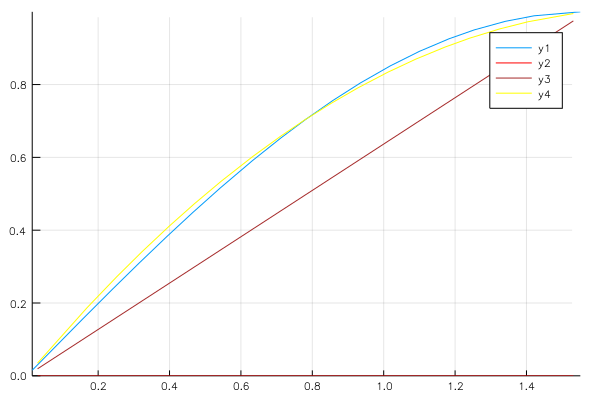

In [1]:
using Plots, QuadGK
f = sin
a, b = 0, pi/2
plot(f, a, b)
plot!(poly_interp(f, interpolating_nodes(a, b, 0)), color=:red)
plot!(poly_interp(f, interpolating_nodes(a, b, 1)), color=:brown)
plot!(poly_interp(f, interpolating_nodes(a, b, 2)), color=:yellow)

<p>How accurate for the sine function</p>

In [1]:
quadgk(f, a, b)  # 1.0

(0.9999999999999999, 1.1102230246251565e-16)

In [1]:
[newton_cotes(f, a, b, i) for i in 0:6] .- 1.0

7-element Array{Float64,1}:
 -1.0       
 -0.214602  
  0.00227988
  0.00100492
 -8.43453e-6
 -4.73861e-6
  2.58372e-8

<p>Should be exact for polynomials of degree $n$ or less – but not necessarily more:</p>

In [1]:
a, b = 0, 1
function err(n)
  fn = x -> x^n  # x-> x^(n+1)
  nodes = interpolating_nodes(a, b, n)
  p = poly_interp(fn, nodes)
  newton_cotes(p, a, b, n) - quadgk(fn, a, b)[1]
end
[err(n) for n in 0:6]

7-element Array{Float64,1}:
  0.0        
  0.0        
  5.55112e-17
  5.55112e-17
 -2.77556e-17
 -2.77556e-17
 -5.55112e-17

<h2>Gauss quadrature</h2>

<p>Legendre polynomials satisfy $P_0=1$, $P_1(x) = x$, and $(n+1)P_{n+1}(x) = (2n+1)xP_n(x) -nP_{n-1}(x)$.</p>

In [1]:
using SymPy
@vars x
ps = Sym[1, x]
for n = 1:5
   pn, pn_1 = ps[end], ps[end-1]
   p =( (2n+1) * x*pn - n*pn_1 ) * (1// (n+1))
   push!(ps, simplify(p))
end
ps

<p>We were told these were <em>orthogonal</em>:</p>

In [1]:
w = 1
[integrate(ps[i] * ps[j] * w, (x, -1, 1)) for i in eachindex(ps), j in eachindex(ps) if i < j]

<p>We were told that these give exact quadrature for polynomials in $\Pi_{2n+1}$.</p>

In [1]:
n = 5
a,b = -1, 1
pn = ps[n+1]  # 1 - based
nodes = solve(pn)  # solve p(x) == 0  

In [1]:
function err(i)
   fn = x -> x^i
   Fn = x -> x^(i+1)/(i+1)
   quadrature(fn, a, b, N.(nodes)) - (Fn(b) - Fn(a))
end
n = length(nodes) - 1   
[err(i) for i in 0:2n+1]

10-element Array{Float64,1}:
 -2.22045e-16
 -1.11022e-16
  0.0        
 -5.55112e-17
  0.0        
 -5.55112e-17
  0.0        
 -5.55112e-17
  0.0        
 -4.16334e-17

<p>But 10th degree polys are not necessarily exact:</p>

In [1]:
fn = x -> x^10
Fn = x -> x^11/11
quadrature(fn, a, b, N.(nodes)) - (Fn(b) - Fn(a))

-0.002931812455622018

<h2>Error</h2>

<p>Thm 4 on p497 has: if $f$ is in $C^{2n}([a,b])$ where $g(x)$ is of degree $n$ (so that there are $n$ nodes) then (note $n-1$):</p>


$$
E = \int_a^b f(x) w(x)dx - \sum_{i-1}^{n-1} f(x_i) A_i
= \frac{f^{(2n)}(\xi)}{(2n)!} \int_a^b q^2(x) w(x) dx
= \frac{f^{(2n)}(\xi)}{(2n)!} \langle q,q \rangle_w
$$


<p>Here $q(x) = \Pi(x - x_i)$.</p>

<p>For this $n=5$ we have the exact integral</p>

In [1]:
q = prod(x-xi for xi in nodes)
integrate(q*q*w, (x, a, b))

<p>So for $f(x) = x^{10}$  we have $f^{(10)}(\xi)/10! = 1$ and so the error is</p>

In [1]:
float(integrate(q*q*w, (x, a, b)))

0.0029318124556219796

<p>Which matches what was previously found.</p>

<h3>Simpson's error</h3>

<p>If we used 5 points and simpson's formula, then we would apply simpsons over $x_0, x_1, x_2$ and $x_2, x_3, x_4$. How accurate would that be?</p>

In [1]:
nodes = N.(nodes) # make floating point
quadrature(fn, nodes[1], nodes[3], nodes[1:3]) +
quadrature(fn, nodes[3], nodes[5], nodes[3:5]) - (Fn(1) - Fn(-1))

-0.118219124196878

<p>So quite far off by comparison</p>

<h2>QuadGk</h2>

<p>The <a href="https://github.com/JuliaMath/QuadGK.jl">QuadGK</a> package, as seen, performs integration. The name is now less opaque:</p>

<ul>
<li><p><code>Quad</code> as we are performing quadrature</p>
</li>
<li><p><code>G</code> For Guass</p>
</li>
<li><p><code>K</code> is for Kronrod, who added a computationally important step</p>
</li>
</ul>

<p>The basic idea is to adaptively integrate over a region using Gaussian quadrature. If the estimated error in a region is too large, the region is split in two and Gaussian quadrature is used to investigate each piece. The method is quite efficient.</p>

<p>For example, with errors like $1/n$, $1/n^2$ and $1/n^4$ for Riemann, Trapezoid and Simpsons, we see that it might take 10^4 steps to get machine tolerance accuracy.</p>

<p>For example, to integrate $\sin(x)$ over $[0, \pi]$ using Simpson's we have</p>

In [1]:
simpson(f, a, b) = 1/6 * (f(a) + 4f((a+b)/2) + f(b))
a, b = 0, pi
n = 10_000
xs = linspace(a, b, n)
sum(simpson(sin, a, b)*(b-a) for (a,b) in zip(xs[1:end-1], xs[2:end])) - 2.0

-1.1102230246251565e-15

<p>How many function calls is this?</p>

In [1]:
mutable struct CountingFunction
  n::Int
  f::Function
  CountingFunction(f) = new(0, f)
end
(F::CountingFunction)(x) = (F.n += 1; F.f(x))

<p>And</p>

In [1]:
Sin = CountingFunction(sin)
sum(simpson(Sin, a, b)*(b-a) for (a,b) in zip(xs[1:end-1], xs[2:end])) - 2.0

-1.1102230246251565e-15

<p>How many steps:</p>

In [1]:
Sin.n

29997

<p>Whereas for <code>quadgk</code>:</p>

In [1]:
Sin = CountingFunction(sin)
quadgk(Sin, 0, pi)

(2.0, 1.7905676941154525e-12)

<p>and</p>

In [1]:
Sin.n

15